In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
plt.style.use('fivethirtyeight')
%matplotlib inline 

Import the data (make sure you update this on a daily basis)

In [3]:
confirmed_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('04-04-2020.csv')

In [4]:
latest_data.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,45001.0,Abbeville,South Carolina,US,2020-04-04 23:34:21,34.223334,-82.461707,6,0,0,0,"Abbeville, South Carolina, US"
1,22001.0,Acadia,Louisiana,US,2020-04-04 23:34:21,30.295065,-92.414197,65,2,0,0,"Acadia, Louisiana, US"
2,51001.0,Accomack,Virginia,US,2020-04-04 23:34:21,37.767072,-75.632346,8,0,0,0,"Accomack, Virginia, US"
3,16001.0,Ada,Idaho,US,2020-04-04 23:34:21,43.452658,-116.241552,360,3,0,0,"Ada, Idaho, US"
4,19001.0,Adair,Iowa,US,2020-04-04 23:34:21,41.330756,-94.471059,1,0,0,0,"Adair, Iowa, US"


In [5]:
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,110,110,120,170,174,237,273,281,299,349
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,186,197,212,223,243,259,277,304,333,361
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,409,454,511,584,716,847,986,1171,1251,1320
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,267,308,334,370,376,390,428,439,466,501
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,4,5,7,7,7,8,8,8,10,14


In [6]:
cols = confirmed_df.keys()

Get all the dates for the outbreak

In [7]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
recoveries = recoveries_df.loc[:, cols[4]:cols[-1]]

In [12]:
dates = confirmed.keys()
world_cases = []
total_deaths = [] 
mortality_rate = []
recovery_rate = [] 
total_recovered = [] 
total_active = [] 
tunisia_cases = [] 
italy_cases = []
us_cases = [] 
spain_cases = [] 
france_cases = [] 

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    recovered_sum = recoveries[i].sum()
    
    # confirmed, deaths, recovered, and active
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    total_recovered.append(recovered_sum)
    total_active.append(confirmed_sum-death_sum-recovered_sum)
    
    # calculate rates
    mortality_rate.append(death_sum/confirmed_sum)
    recovery_rate.append(recovered_sum/confirmed_sum)

    # case studies 
    tunisia_cases.append(confirmed_df[confirmed_df['Country/Region']=='Tunisia'][i].sum())
    italy_cases.append(confirmed_df[confirmed_df['Country/Region']=='Italy'][i].sum())
    us_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())
    spain_cases.append(confirmed_df[confirmed_df['Country/Region']=='Spain'][i].sum())
    france_cases.append(confirmed_df[confirmed_df['Country/Region']=='France'][i].sum())

Getting daily increases

In [14]:
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

world_daily_increase = daily_increase(world_cases)
tunisia_daily_increase = daily_increase(tunisia_cases)
italy_daily_increase = daily_increase(italy_cases)
us_daily_increase = daily_increase(us_cases)
spain_daily_increase = daily_increase(spain_cases)
france_daily_increase = daily_increase(france_cases)

In [15]:
days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)
world_cases = np.array(world_cases).reshape(-1, 1)
total_deaths = np.array(total_deaths).reshape(-1, 1)
total_recovered = np.array(total_recovered).reshape(-1, 1)

Future forcasting

In [16]:
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

Convert integer into datetime for better visualization

In [95]:
start = '04/04/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [96]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, world_cases, test_size=0.10, shuffle=False) 

Model for predicting # of confirmed cases. I am using support vector machine, bayesian ridge , and linear regression in this example. 

In [97]:
# use this to find the optimal parameters for SVR
# c = [0.01, 0.1, 1]
# gamma = [0.01, 0.1, 1]
# epsilon = [0.01, 0.1, 1]
# shrinking = [True, False]
# degree = [3, 4, 5, 6, 7]

# svm_grid = {'C': c, 'gamma' : gamma, 'epsilon': epsilon, 'shrinking' : shrinking, 'degree': degree}

# svm = SVR(kernel='poly')
# svm_search = RandomizedSearchCV(svm, svm_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=30, verbose=1)
# svm_search.fit(X_train_confirmed, y_train_confirmed)

In [98]:
# svm_search.best_params_

In [99]:
# svm_confirmed = svm_search.best_estimator_
svm_confirmed = SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=7, C=0.1)
svm_confirmed.fit(X_train_confirmed, y_train_confirmed)
svm_pred = svm_confirmed.predict(future_forcast)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MAE: 24676.382159709974
MSE: 1032979715.9709945


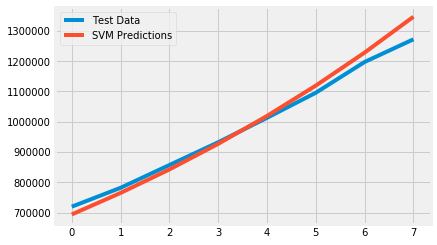

In [100]:
# check against testing data
svm_test_pred = svm_confirmed.predict(X_test_confirmed)
plt.plot(y_test_confirmed)
plt.plot(svm_test_pred)
plt.legend(['Test Data', 'SVM Predictions'])
print('MAE:', mean_absolute_error(svm_test_pred, y_test_confirmed))
print('MSE:',mean_squared_error(svm_test_pred, y_test_confirmed))

In [101]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree=5)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

In [102]:
# polynomial regression
linear_model = LinearRegression(normalize=True, fit_intercept=False)
linear_model.fit(poly_X_train_confirmed, y_train_confirmed)
test_linear_pred = linear_model.predict(poly_X_test_confirmed)
linear_pred = linear_model.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_linear_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_linear_pred, y_test_confirmed))

MAE: 98258.64633954276
MSE: 14246138358.676403


In [103]:
print(linear_model.coef_)

[[-5.33691848e+02  3.43041214e+02  7.76490424e+01  6.46109666e+00
  -3.28833406e-01  3.73624538e-03]]


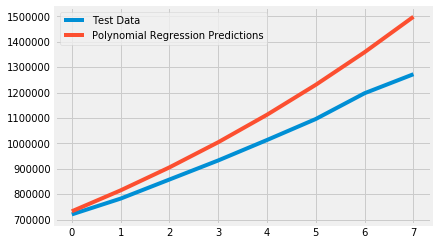

In [104]:
plt.plot(y_test_confirmed)
plt.plot(test_linear_pred)
plt.legend(['Test Data', 'Polynomial Regression Predictions'])

In [105]:
# bayesian ridge polynomial regression
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(fit_intercept=False, normalize=True)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(poly_X_train_confirmed, y_train_confirmed)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   37.0s finished
C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,
                                           compute_score=False, copy_X=True,
                                           fit_intercept=False, lambda_1=1e-06,
                                           lambda_2=1e-06, n_iter=300,
                                           normalize=True, tol=0.001,
                                           verbose=False),
                   iid='warn', n_iter=40, n_jobs=-1,
                   param_distributions={'alpha_1': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'alpha_2': [1e-07, 1e-06, 1e-05,
                                                    0.0001],
                                        'lambda_1': [1e-07, 1e-06, 1e-05,
                                                     0.0001],
                                        'lambda_2': [1e

In [106]:
bayesian_search.best_params_

{'tol': 0.0001,
 'lambda_2': 1e-07,
 'lambda_1': 0.0001,
 'alpha_2': 0.0001,
 'alpha_1': 1e-05}

In [107]:
bayesian_confirmed = bayesian_search.best_estimator_
test_bayesian_pred = bayesian_confirmed.predict(poly_X_test_confirmed)
bayesian_pred = bayesian_confirmed.predict(poly_future_forcast)
print('MAE:', mean_absolute_error(test_bayesian_pred, y_test_confirmed))
print('MSE:',mean_squared_error(test_bayesian_pred, y_test_confirmed))

MAE: 153255.22046281584
MSE: 25984657037.346046


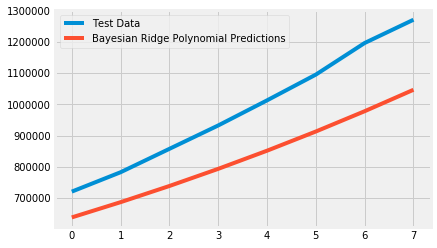

In [108]:
plt.plot(y_test_confirmed)
plt.plot(test_bayesian_pred)
plt.legend(['Test Data', 'Bayesian Ridge Polynomial Predictions'])

 Graphing the number of confirmed cases, active cases, deaths, recoveries, mortality rate, and recovery rate

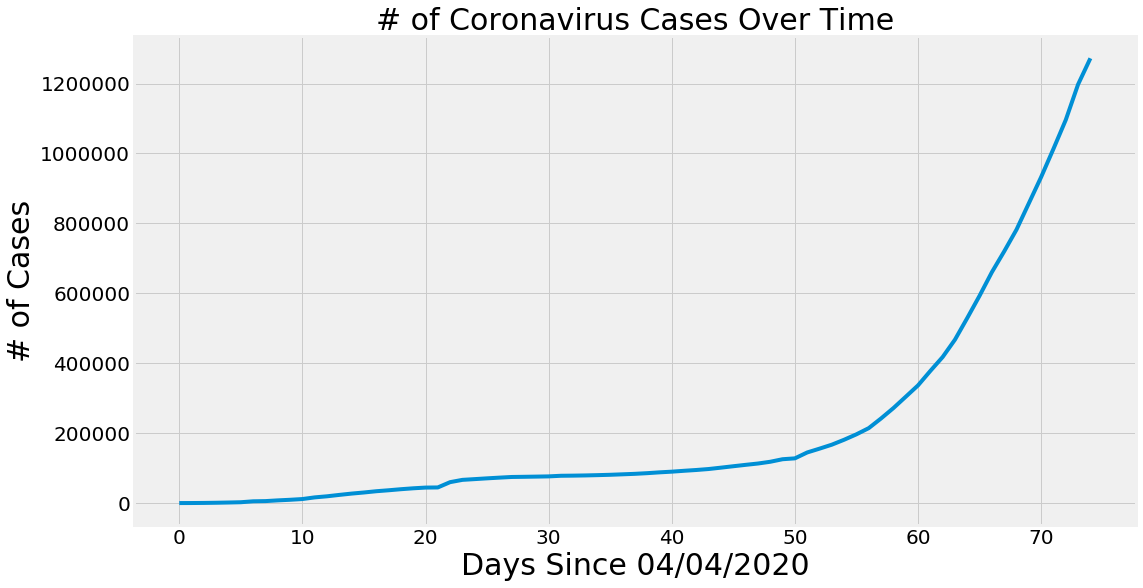

In [112]:
adjusted_dates = adjusted_dates.reshape(1, -1)[0]
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 04/04/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

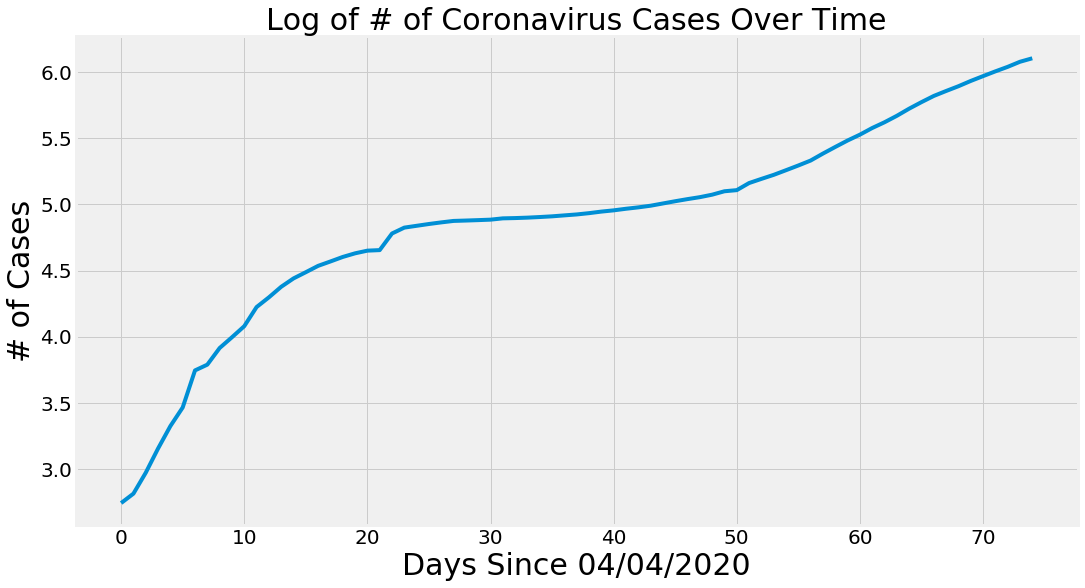

In [113]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, np.log10(world_cases))
plt.title('Log of # of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 04/04/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

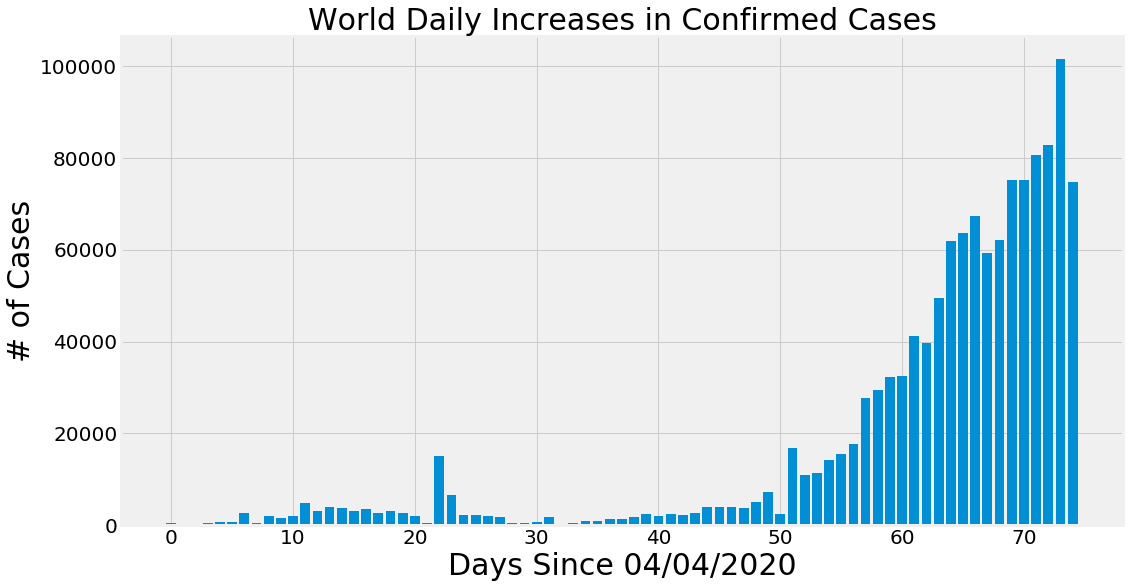

In [115]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, world_daily_increase)
plt.title('World Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 04/04/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

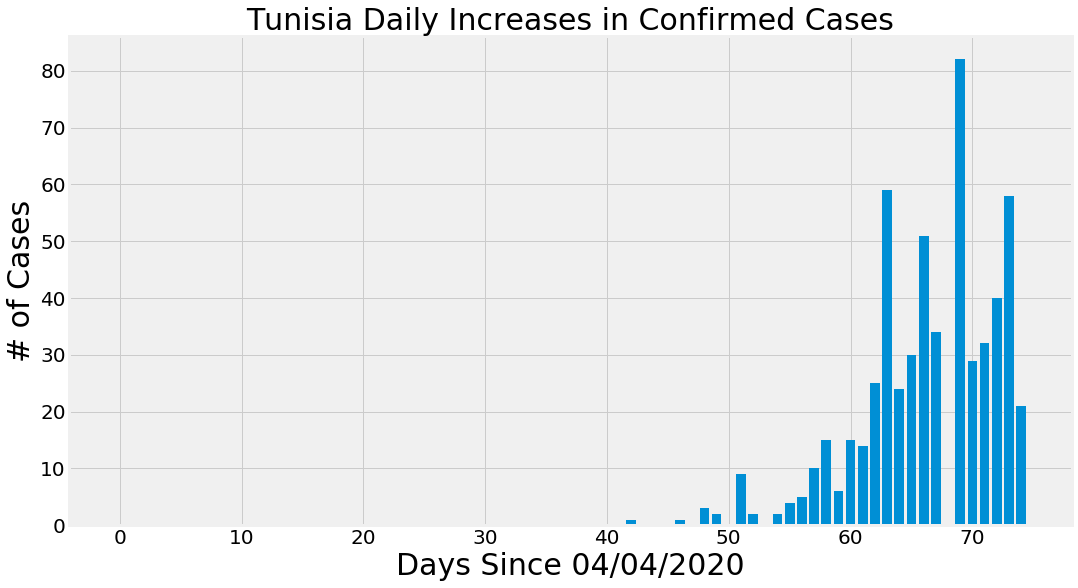

In [116]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, tunisia_daily_increase)
plt.title('Tunisia Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 04/04/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

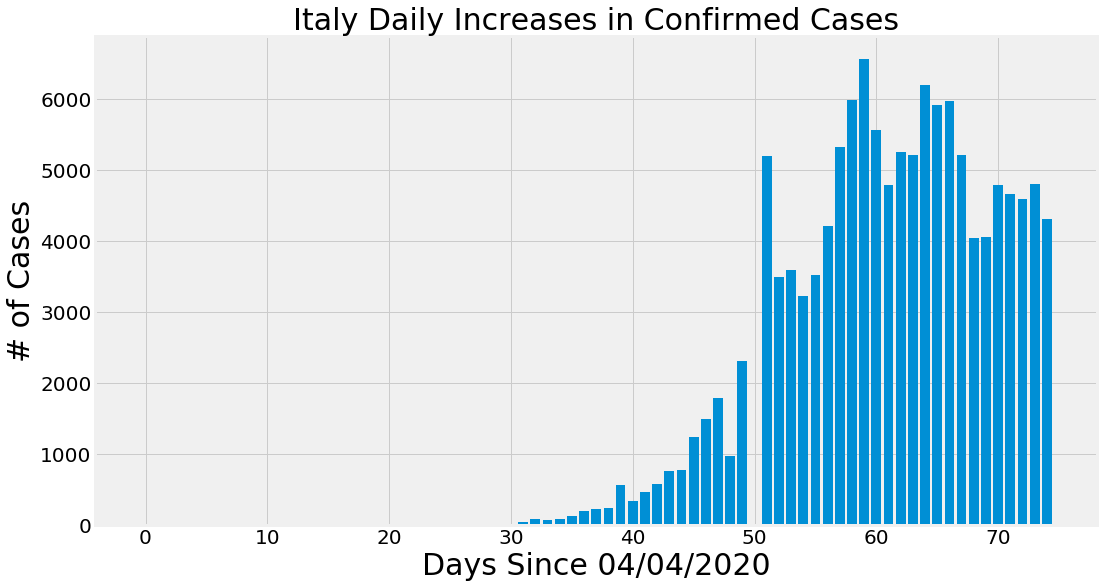

In [117]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, italy_daily_increase)
plt.title('Italy Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 04/04/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

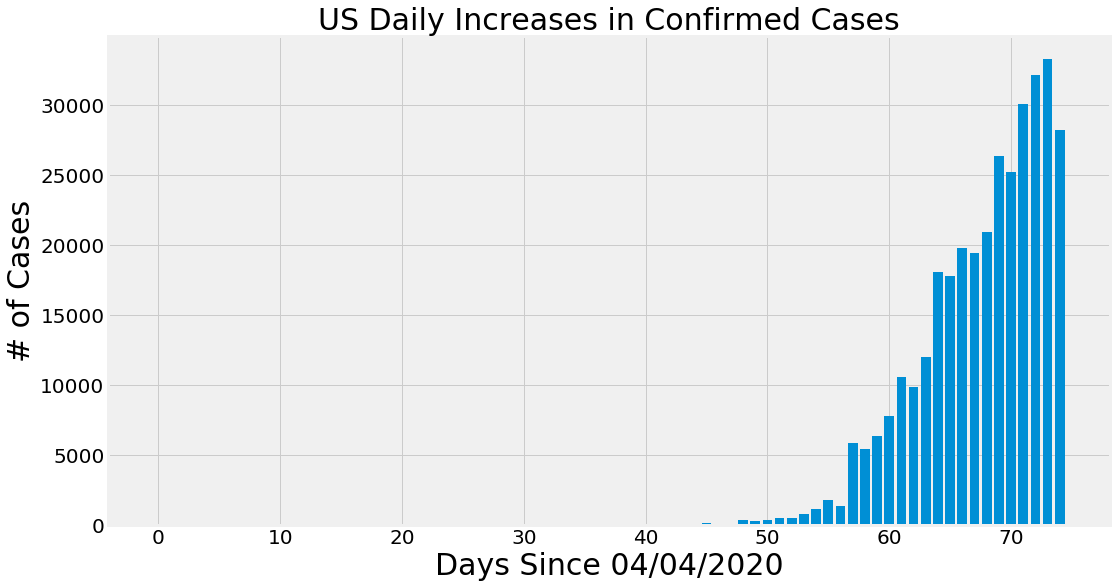

In [118]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, us_daily_increase)
plt.title('US Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 04/04/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

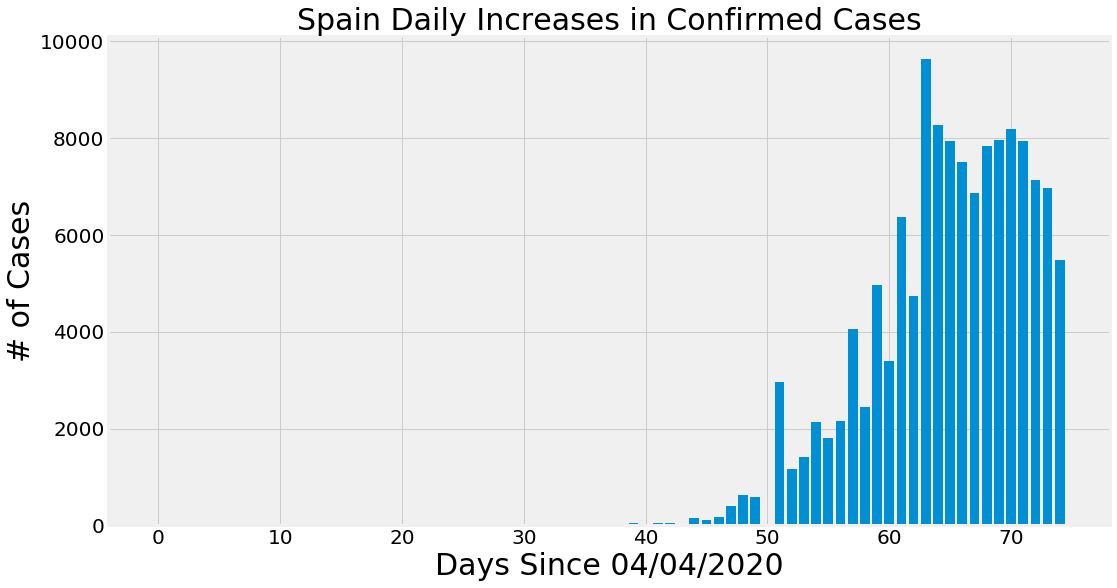

In [119]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, spain_daily_increase)
plt.title('Spain Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 04/04/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

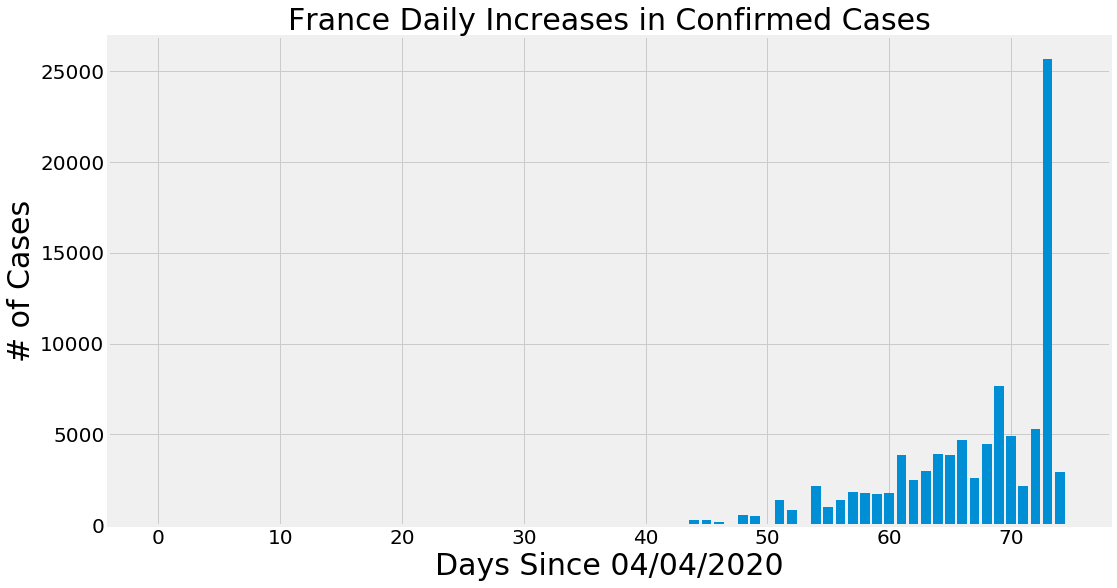

In [120]:
plt.figure(figsize=(16, 9))
plt.bar(adjusted_dates, france_daily_increase)
plt.title('France Daily Increases in Confirmed Cases', size=30)
plt.xlabel('Days Since 04/04/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

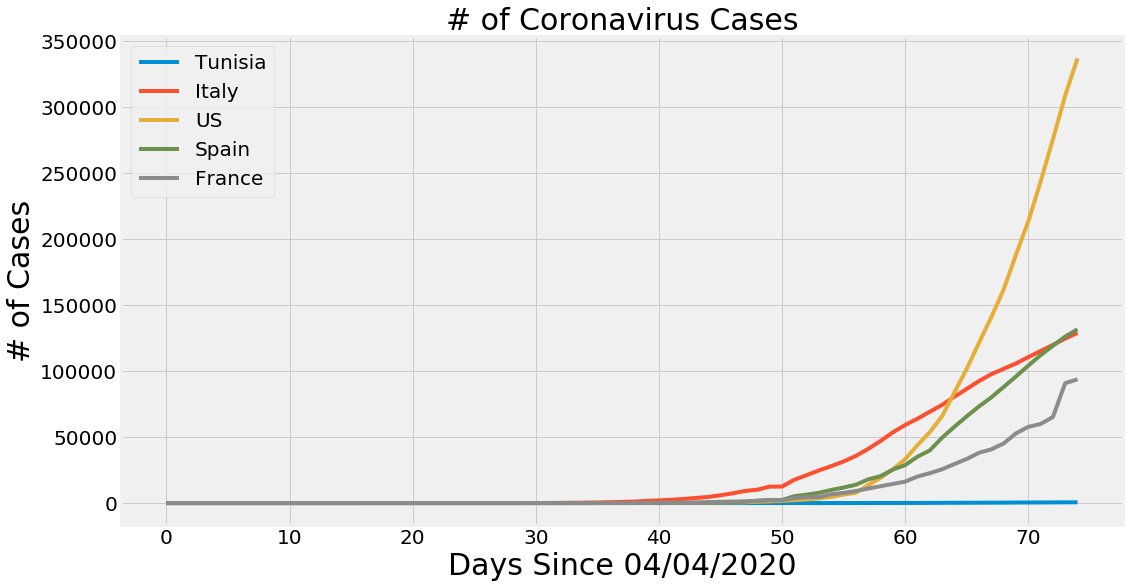

In [122]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, tunisia_cases)
plt.plot(adjusted_dates, italy_cases)
plt.plot(adjusted_dates, us_cases)
plt.plot(adjusted_dates, spain_cases)
plt.plot(adjusted_dates, france_cases)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Days Since 04/04/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Tunisia', 'Italy', 'US', 'Spain', 'France'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

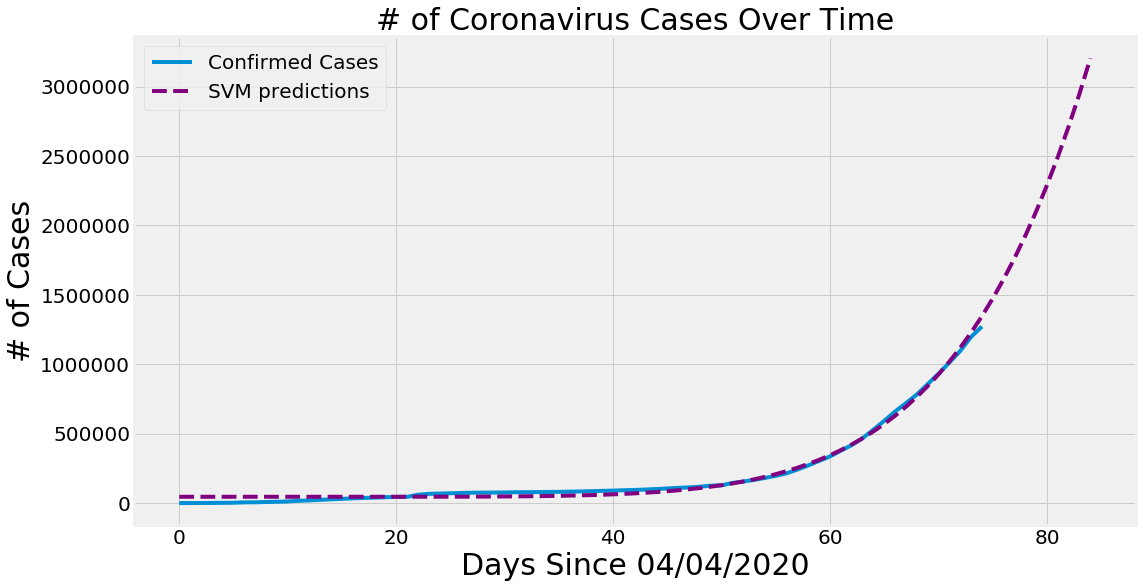

In [123]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, svm_pred, linestyle='dashed', color='purple')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 04/04/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'SVM predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

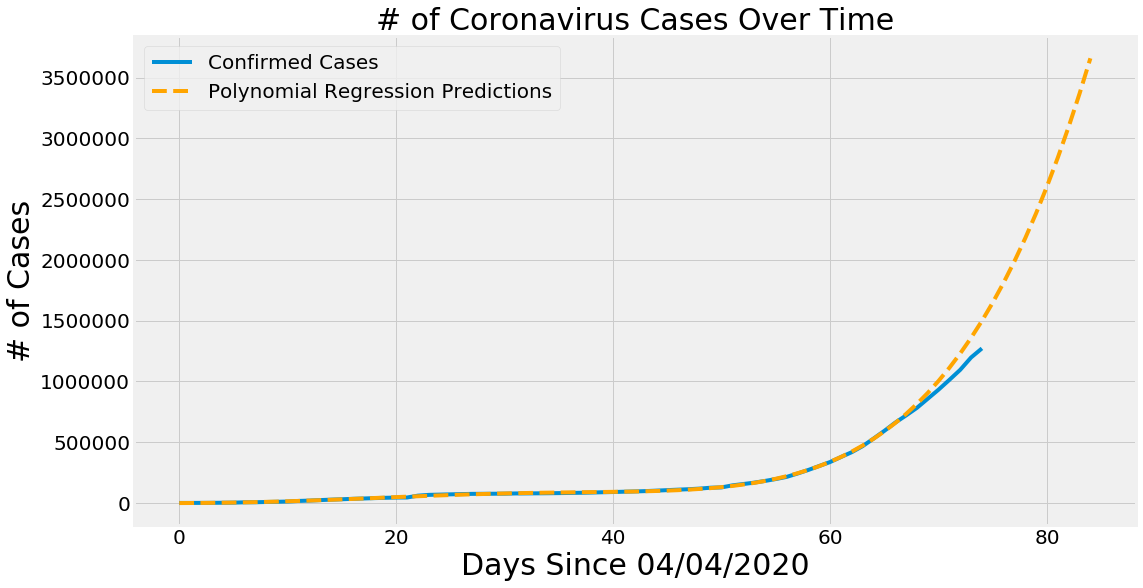

In [124]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, linear_pred, linestyle='dashed', color='orange')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since 04/04/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Polynomial Regression Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

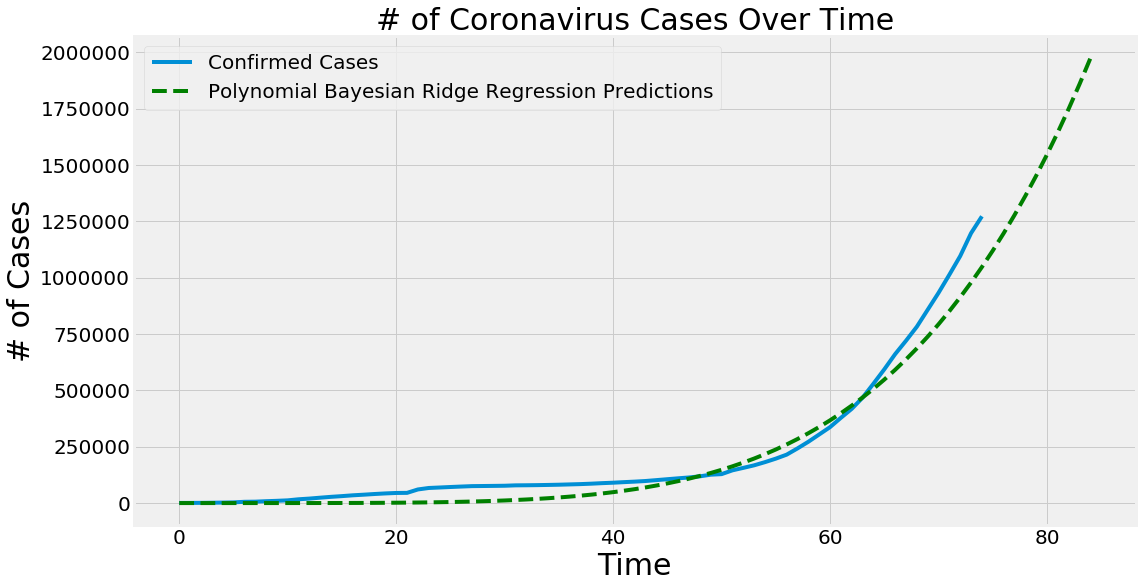

In [125]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, world_cases)
plt.plot(future_forcast, bayesian_pred, linestyle='dashed', color='green')
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time', size=30)
plt.ylabel('# of Cases', size=30)
plt.legend(['Confirmed Cases', 'Polynomial Bayesian Ridge Regression Predictions'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [126]:
# Future predictions using SVM 
print('SVM future predictions:')
set(zip(future_forcast_dates[-10:], np.round(svm_pred[-10:])))

SVM future predictions:


{('06/18/2020', 1474637.0),
 ('06/19/2020', 1613444.0),
 ('06/20/2020', 1763653.0),
 ('06/21/2020', 1926035.0),
 ('06/22/2020', 2101399.0),
 ('06/23/2020', 2290601.0),
 ('06/24/2020', 2494537.0),
 ('06/25/2020', 2714153.0),
 ('06/26/2020', 2950439.0),
 ('06/27/2020', 3204439.0)}

In [127]:
# Future predictions using Polynomial Regression 
linear_pred = linear_pred.reshape(1,-1)[0]
print('Polynomial regression future predictions:')
set(zip(future_forcast_dates[-10:], np.round(linear_pred[-10:])))

Polynomial regression future predictions:


{('06/18/2020', 1649536.0),
 ('06/19/2020', 1813052.0),
 ('06/20/2020', 1989681.0),
 ('06/21/2020', 2180172.0),
 ('06/22/2020', 2385297.0),
 ('06/23/2020', 2605858.0),
 ('06/24/2020', 2842682.0),
 ('06/25/2020', 3096626.0),
 ('06/26/2020', 3368575.0),
 ('06/27/2020', 3659442.0)}

In [128]:
# Future predictions using Linear Regression 
print('Ridge regression future predictions:')
set(zip(future_forcast_dates[-10:], np.round(bayesian_pred[-10:])))

Ridge regression future predictions:


{('06/18/2020', 1119839.0),
 ('06/19/2020', 1196481.0),
 ('06/20/2020', 1277263.0),
 ('06/21/2020', 1362351.0),
 ('06/22/2020', 1451915.0),
 ('06/23/2020', 1546128.0),
 ('06/24/2020', 1645169.0),
 ('06/25/2020', 1749222.0),
 ('06/26/2020', 1858475.0),
 ('06/27/2020', 1973120.0)}

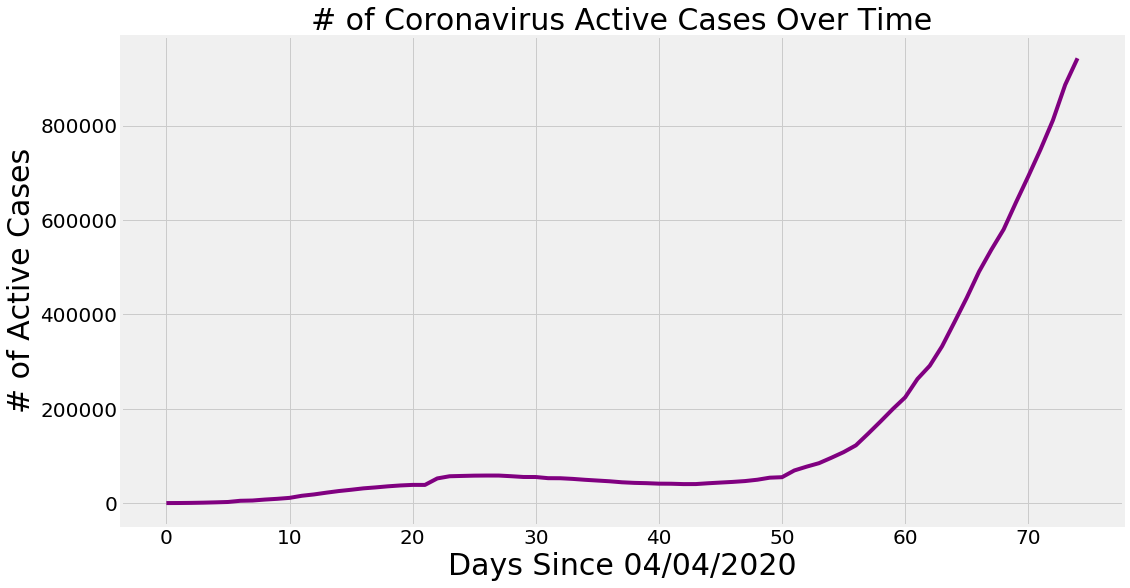

In [130]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_active, color='purple')
plt.title('# of Coronavirus Active Cases Over Time', size=30)
plt.xlabel('Days Since 04/04/2020', size=30)
plt.ylabel('# of Active Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

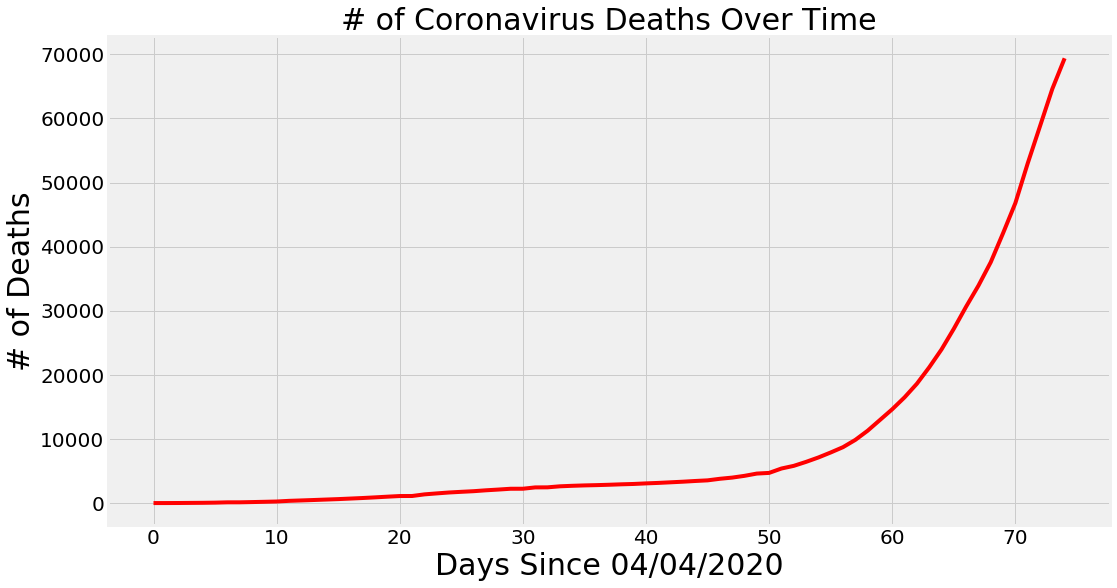

In [131]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_deaths, color='red')
plt.title('# of Coronavirus Deaths Over Time', size=30)
plt.xlabel('Days Since 04/04/2020', size=30)
plt.ylabel('# of Deaths', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

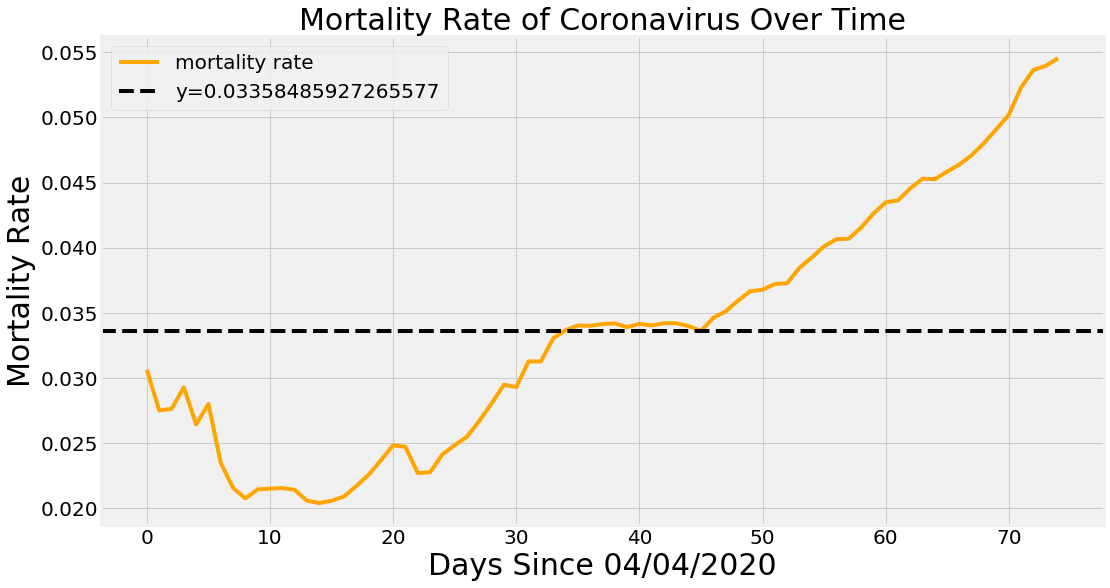

In [132]:
mean_mortality_rate = np.mean(mortality_rate)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, mortality_rate, color='orange')
plt.axhline(y = mean_mortality_rate,linestyle='--', color='black')
plt.title('Mortality Rate of Coronavirus Over Time', size=30)
plt.legend(['mortality rate', 'y='+str(mean_mortality_rate)], prop={'size': 20})
plt.xlabel('Days Since 04/04/2020', size=30)
plt.ylabel('Mortality Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

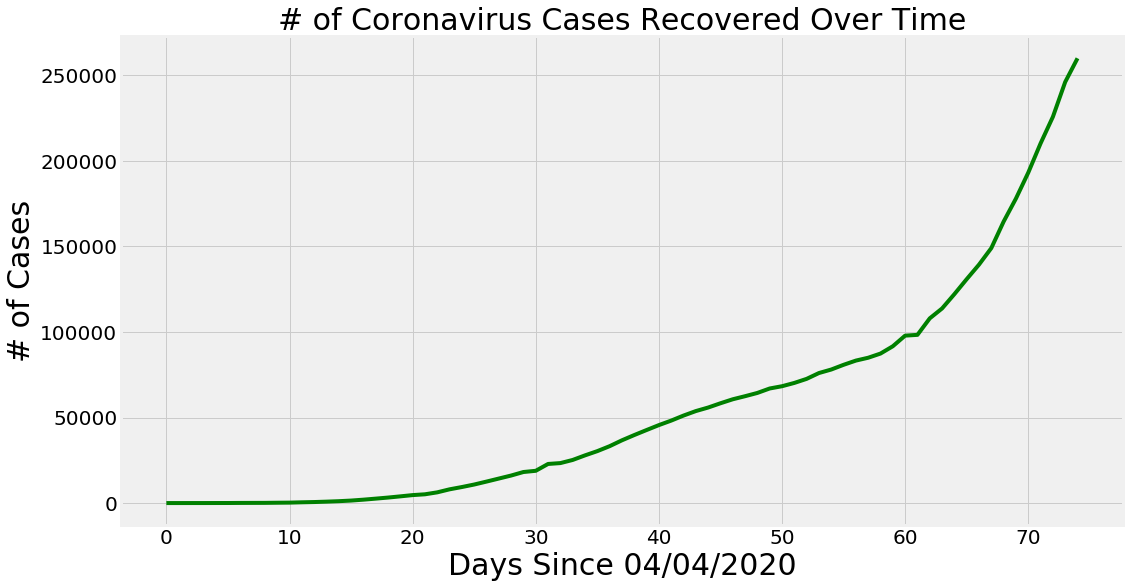

In [133]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_recovered, color='green')
plt.title('# of Coronavirus Cases Recovered Over Time', size=30)
plt.xlabel('Days Since 04/04/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

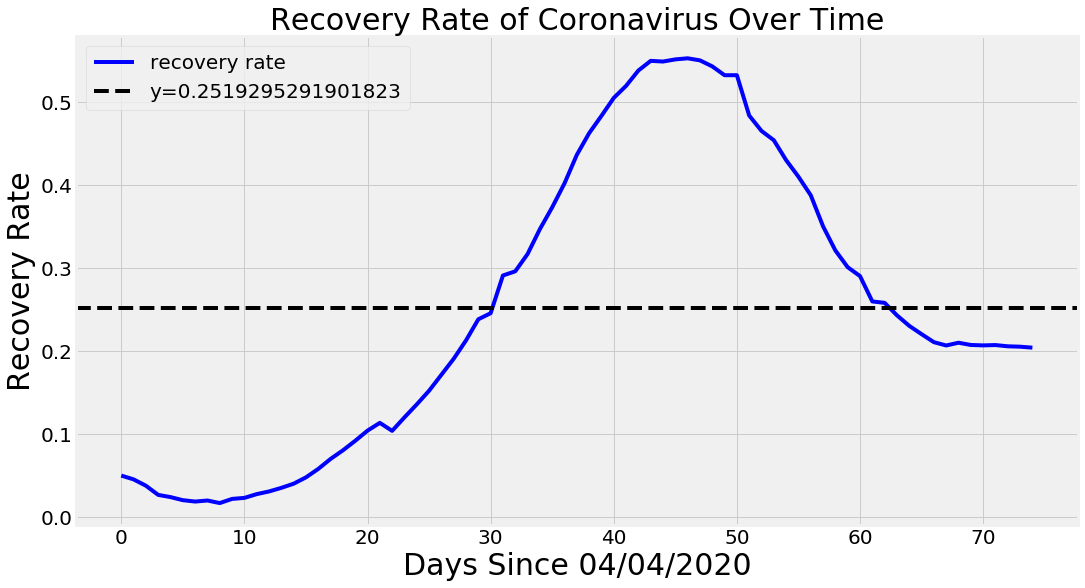

In [134]:
mean_recovery_rate = np.mean(recovery_rate)
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, recovery_rate, color='blue')
plt.axhline(y = mean_recovery_rate,linestyle='--', color='black')
plt.title('Recovery Rate of Coronavirus Over Time', size=30)
plt.legend(['recovery rate', 'y='+str(mean_recovery_rate)], prop={'size': 20})
plt.xlabel('Days Since 04/04/2020', size=30)
plt.ylabel('Recovery Rate', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Graphing deaths against recoveries

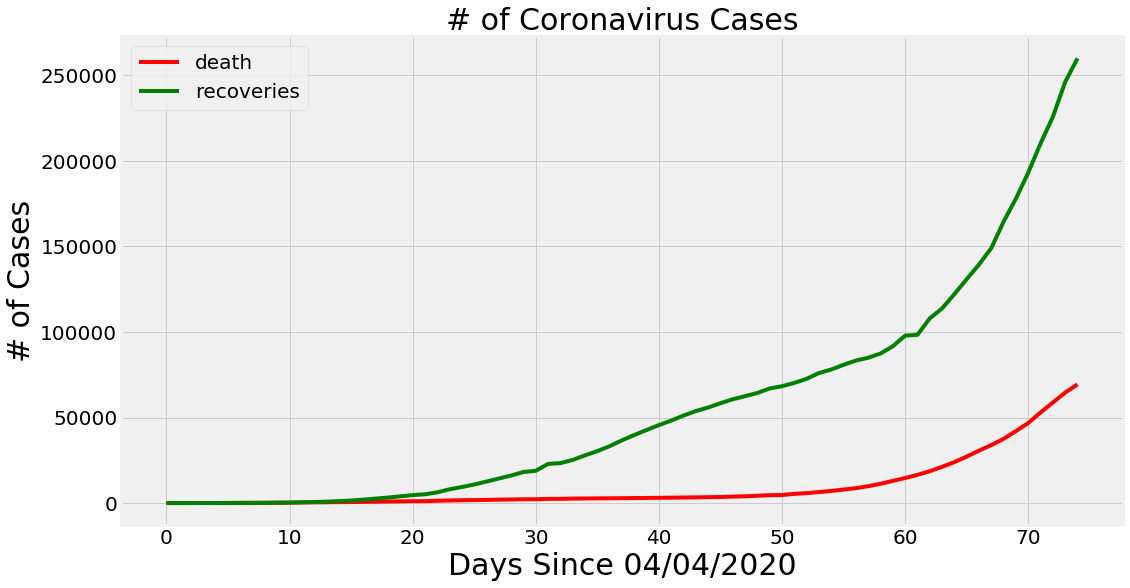

In [135]:
plt.figure(figsize=(16, 9))
plt.plot(adjusted_dates, total_deaths, color='r')
plt.plot(adjusted_dates, total_recovered, color='green')
plt.legend(['death', 'recoveries'], loc='best', fontsize=20)
plt.title('# of Coronavirus Cases', size=30)
plt.xlabel('Days Since 04/04/2020', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Plotting the number of deaths against the number of recoveries

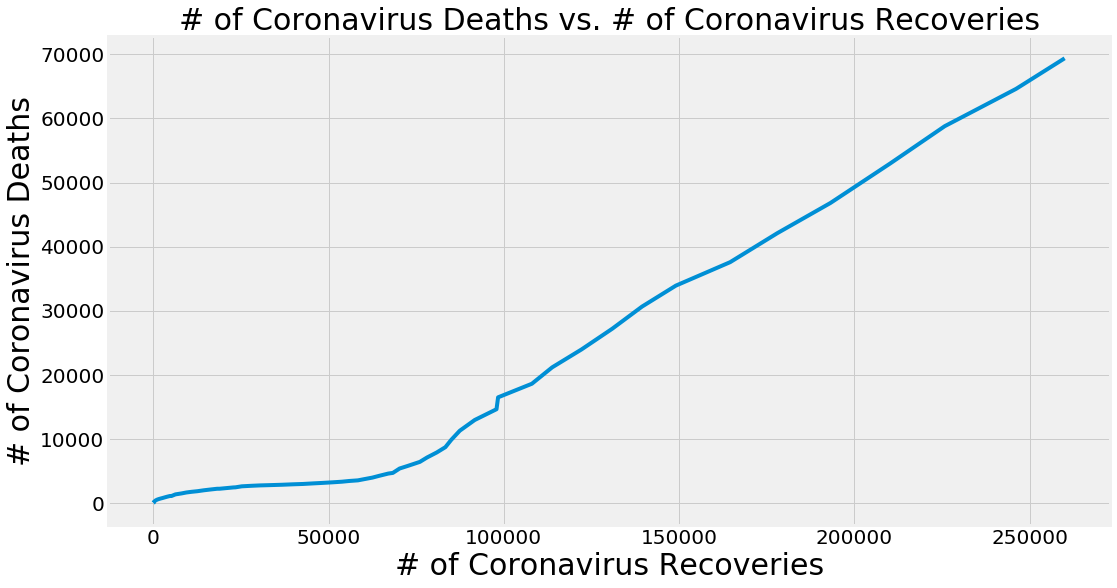

In [136]:
plt.figure(figsize=(16, 9))
plt.plot(total_recovered, total_deaths)
plt.title('# of Coronavirus Deaths vs. # of Coronavirus Recoveries', size=30)
plt.xlabel('# of Coronavirus Recoveries', size=30)
plt.ylabel('# of Coronavirus Deaths', size=30)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

Getting information about countries/regions that have confirmed coronavirus cases

In [137]:
unique_countries =  list(latest_data['Country_Region'].unique())

In [138]:
country_confirmed_cases = []
country_death_cases = [] 
country_active_cases = []
country_recovery_cases = []
country_mortality_rate = [] 

no_cases = []
for i in unique_countries:
    cases = latest_data[latest_data['Country_Region']==i]['Confirmed'].sum()
    if cases > 0:
        country_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
        
for i in no_cases:
    unique_countries.remove(i)
    
# sort countries by the number of confirmed cases
unique_countries = [k for k, v in sorted(zip(unique_countries, country_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_countries)):
    country_confirmed_cases[i] = latest_data[latest_data['Country_Region']==unique_countries[i]]['Confirmed'].sum()
    country_death_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Deaths'].sum())
    country_recovery_cases.append(latest_data[latest_data['Country_Region']==unique_countries[i]]['Recovered'].sum())
    country_active_cases.append(country_confirmed_cases[i] - country_death_cases[i] - country_recovery_cases[i])
    country_mortality_rate.append(country_death_cases[i]/country_confirmed_cases[i])

In [139]:
country_df = pd.DataFrame({'Country Name': unique_countries, 'Number of Confirmed Cases': country_confirmed_cases,
                          'Number of Deaths': country_death_cases, 'Number of Recoveries' : country_recovery_cases, 
                          'Number of Active Cases' : country_active_cases,
                          'Mortality Rate': country_mortality_rate})
# number of cases per country/region

country_df.style.background_gradient(cmap='Greens')

,Country Name,Number of Confirmed Cases,Number of Deaths,Number of Recoveries,Number of Active Cases,Mortality Rate
0,US,308850,8407,14652,285791,0.0272203
1,Spain,126168,11947,34219,80002,0.0946912
2,Italy,124632,15362,20996,88274,0.123259
3,Germany,96092,1444,26400,68248,0.0150273
4,France,90848,7574,15572,67702,0.08337
5,China,82543,3330,76946,2267,0.0403426
6,Iran,55743,3452,19736,32555,0.0619271
7,United Kingdom,42477,4320,215,37942,0.101702
8,Turkey,23934,501,786,22647,0.0209326
9,Switzerland,20505,666,6415,13424,0.0324799


In [140]:
unique_provinces =  list(latest_data['Province_State'].unique())

Getting the latest information about provinces/states that have confirmed coronavirus cases

In [141]:
province_confirmed_cases = []
province_country = [] 
province_death_cases = [] 
province_recovery_cases = []
province_mortality_rate = [] 

no_cases = [] 
for i in unique_provinces:
    cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
    if cases > 0:
        province_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    unique_provinces.remove(i)
    
unique_provinces = [k for k, v in sorted(zip(unique_provinces, province_confirmed_cases), key=operator.itemgetter(1), reverse=True)]
for i in range(len(unique_provinces)):
    province_confirmed_cases[i] = latest_data[latest_data['Province_State']==unique_provinces[i]]['Confirmed'].sum()
    province_country.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Country_Region'].unique()[0])
    province_death_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Deaths'].sum())
    province_recovery_cases.append(latest_data[latest_data['Province_State']==unique_provinces[i]]['Recovered'].sum())
    province_mortality_rate.append(province_death_cases[i]/province_confirmed_cases[i])

In [142]:
# number of cases per province/state/city
province_df = pd.DataFrame({'Province/State Name': unique_provinces, 'Country': province_country, 'Number of Confirmed Cases': province_confirmed_cases,
                          'Number of Deaths': province_death_cases, 'Number of Recoveries' : province_recovery_cases,
                          'Mortality Rate': province_mortality_rate})
# number of cases per country/region

province_df.style.background_gradient(cmap='Greens')

,Province/State Name,Country,Number of Confirmed Cases,Number of Deaths,Number of Recoveries,Mortality Rate
0,New York,US,113833,3565,0,0.0313178
1,Hubei,China,67803,3207,63762,0.0472988
2,New Jersey,US,34124,846,0,0.0247919
3,Michigan,US,14225,540,0,0.0379613
4,California,US,12837,289,0,0.022513
5,Louisiana,US,12496,409,0,0.0327305
6,Massachusetts,US,11736,216,0,0.0184049
7,Florida,US,11545,195,0,0.0168904
8,Pennsylvania,US,10444,136,0,0.0130218
9,Illinois,US,10357,244,0,0.0235589


In [143]:
nan_indices = [] 

# handle nan if there is any, it is usually a float: float('nan')

for i in range(len(unique_provinces)):
    if type(unique_provinces[i]) == float:
        nan_indices.append(i)

unique_provinces = list(unique_provinces)
province_confirmed_cases = list(province_confirmed_cases)

for i in nan_indices:
    unique_provinces.pop(i)
    province_confirmed_cases.pop(i)

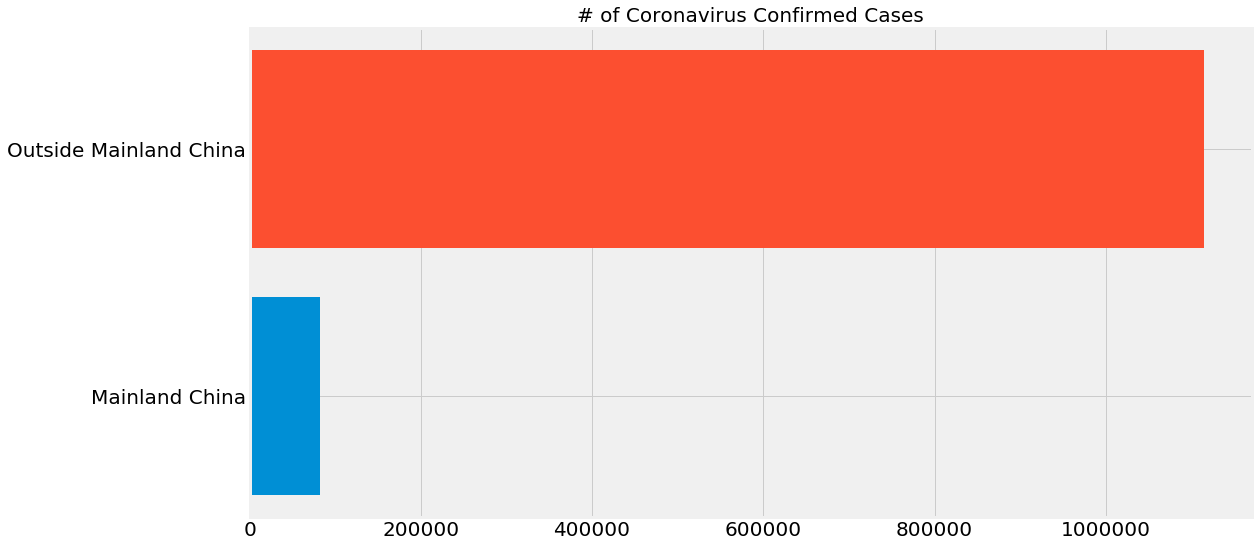

In [144]:
china_confirmed = latest_data[latest_data['Country_Region']=='China']['Confirmed'].sum()
outside_mainland_china_confirmed = np.sum(country_confirmed_cases) - china_confirmed
plt.figure(figsize=(16, 9))
plt.barh('Mainland China', china_confirmed)
plt.barh('Outside Mainland China', outside_mainland_china_confirmed)
plt.title('# of Coronavirus Confirmed Cases', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [145]:
print('Outside Mainland China {} cases:'.format(outside_mainland_china_confirmed))
print('Mainland China: {} cases'.format(china_confirmed))
print('Total: {} cases'.format(china_confirmed+outside_mainland_china_confirmed))

Outside Mainland China 1114862 cases:
Mainland China: 82543 cases
Total: 1197405 cases


In [146]:
# Only show 10 countries with the most confirmed cases, the rest are grouped into the other category
visual_unique_countries = [] 
visual_confirmed_cases = []
others = np.sum(country_confirmed_cases[10:])

for i in range(len(country_confirmed_cases[:10])):
    visual_unique_countries.append(unique_countries[i])
    visual_confirmed_cases.append(country_confirmed_cases[i])
    
visual_unique_countries.append('Others')
visual_confirmed_cases.append(others)

***Visual Representations*** (bar charts and pie charts)

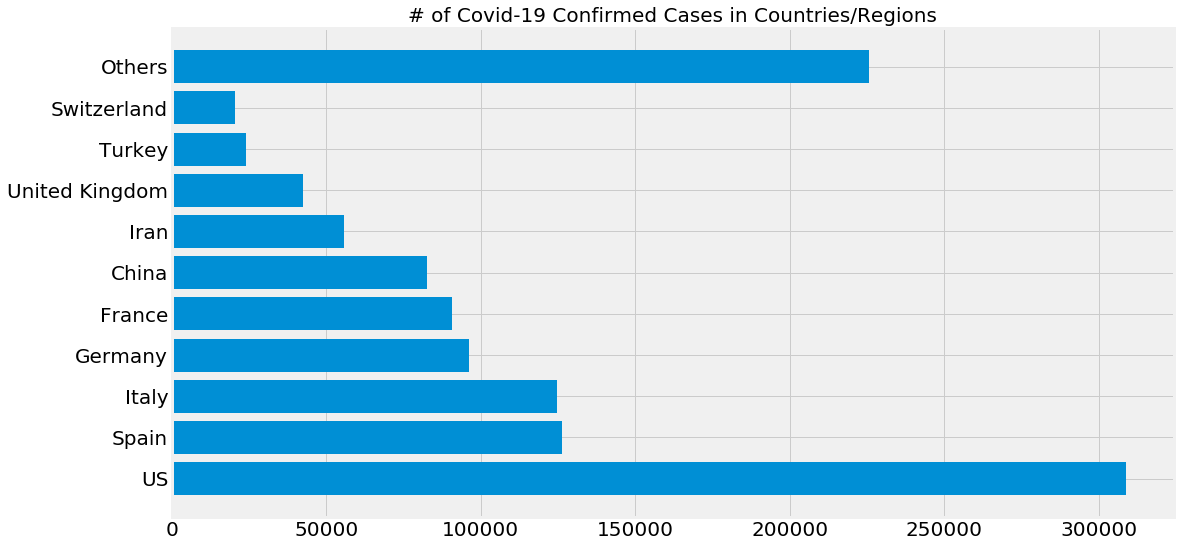

In [147]:
plt.figure(figsize=(16, 9))
plt.barh(visual_unique_countries, visual_confirmed_cases)
plt.title('# of Covid-19 Confirmed Cases in Countries/Regions', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

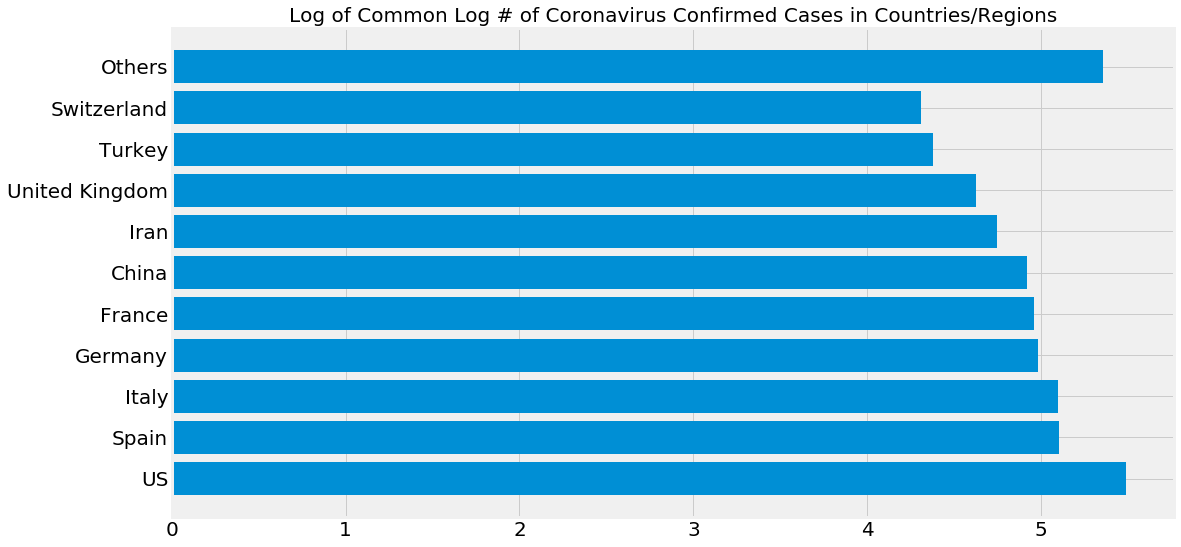

In [148]:
# lets look at it in a logarithmic scale 
log_country_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases]
plt.figure(figsize=(16, 9))
plt.barh(visual_unique_countries, log_country_confirmed_cases)
plt.title('Log of Common Log # of Coronavirus Confirmed Cases in Countries/Regions', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [149]:
# Only show 10 provinces with the most confirmed cases, the rest are grouped into the other category
visual_unique_provinces = [] 
visual_confirmed_cases2 = []
others = np.sum(province_confirmed_cases[10:])
for i in range(len(province_confirmed_cases[:10])):
    visual_unique_provinces.append(unique_provinces[i])
    visual_confirmed_cases2.append(province_confirmed_cases[i])

visual_unique_provinces.append('Others')
visual_confirmed_cases2.append(others)

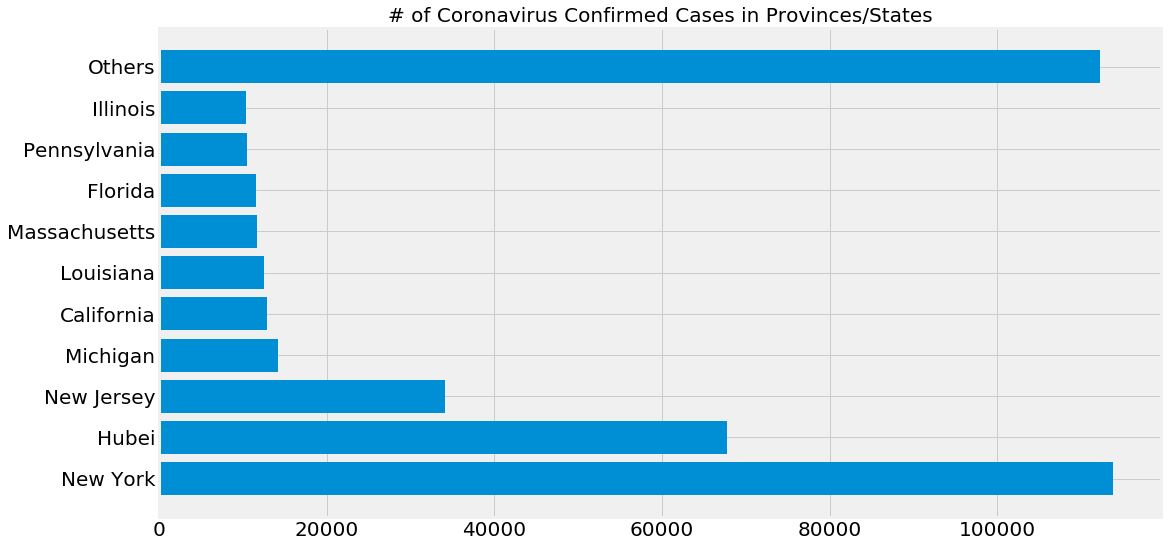

In [150]:
plt.figure(figsize=(16, 9))
plt.barh(visual_unique_provinces, visual_confirmed_cases2)
plt.title('# of Coronavirus Confirmed Cases in Provinces/States', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

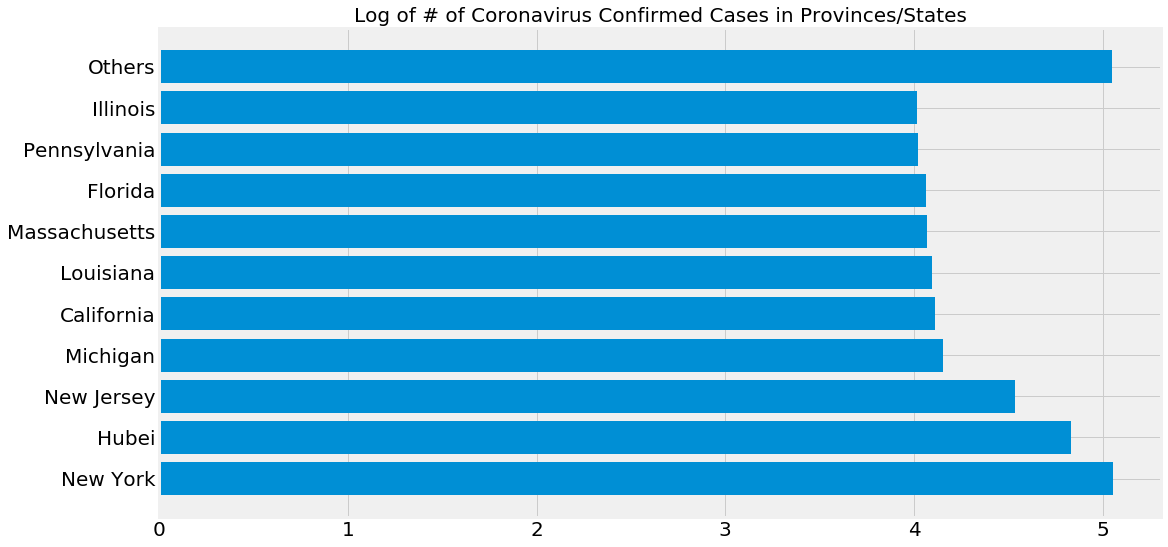

In [151]:
log_province_confirmed_cases = [math.log10(i) for i in visual_confirmed_cases2]
plt.figure(figsize=(16, 9))
plt.barh(visual_unique_provinces, log_province_confirmed_cases)
plt.title('Log of # of Coronavirus Confirmed Cases in Provinces/States', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

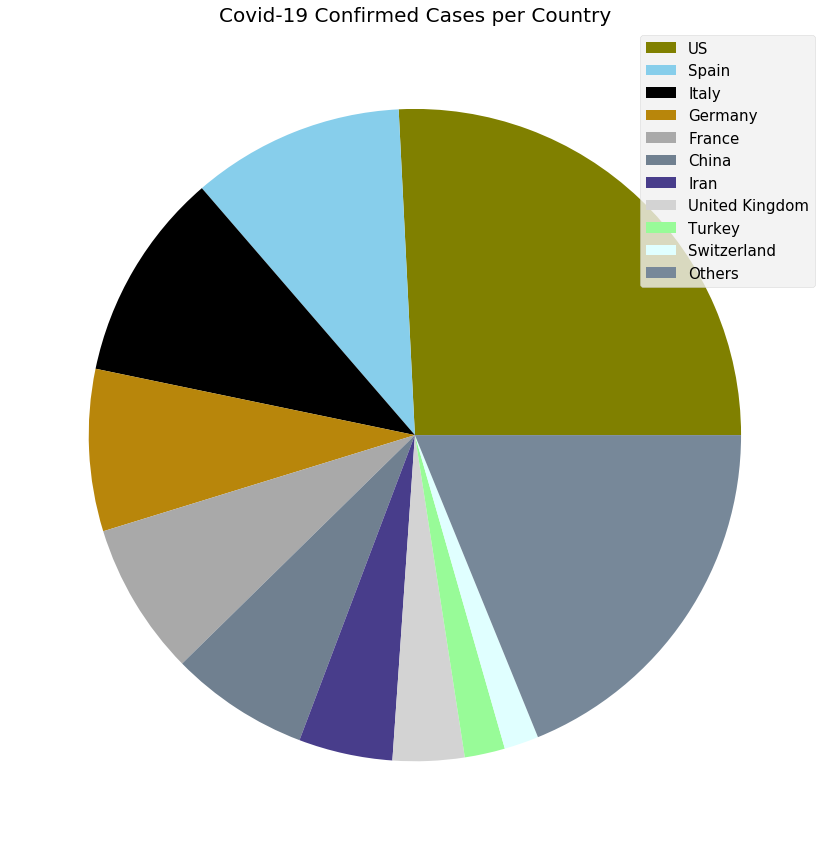

In [152]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(unique_countries))
plt.figure(figsize=(20,15))
plt.title('Covid-19 Confirmed Cases per Country', size=20)
plt.pie(visual_confirmed_cases, colors=c)
plt.legend(visual_unique_countries, loc='best', fontsize=15)
plt.show()

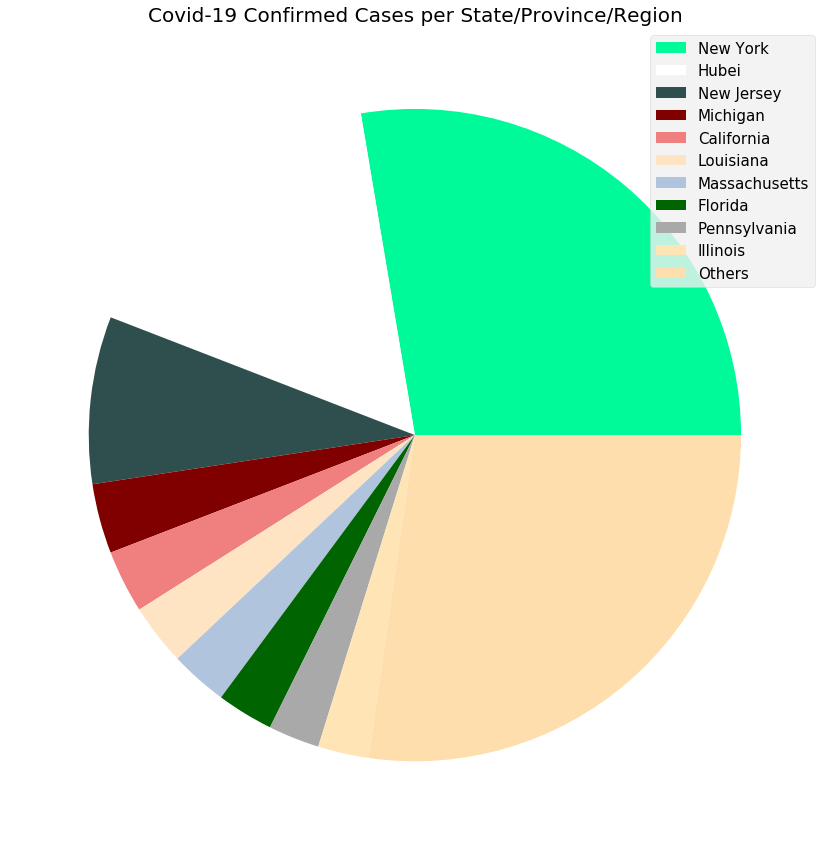

In [153]:
c = random.sample(list(mcolors.CSS4_COLORS.values()),k = len(visual_confirmed_cases2))
plt.figure(figsize=(20,15))
plt.title('Covid-19 Confirmed Cases per State/Province/Region', size=20)
plt.pie(visual_confirmed_cases2, colors=c)
plt.legend(visual_unique_provinces, loc='best', fontsize=15)
plt.show()

In [154]:
# looking at US States
us_regions = list(latest_data[latest_data['Country_Region']=='US']['Province_State'].unique())
us_confirmed_cases = []
no_cases = [] 
for i in us_regions:
    cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
    if cases > 0:
        us_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    us_regions.remove(i)
    
# only show the top 10 states
us_regions = [k for k, v in sorted(zip(us_regions, us_confirmed_cases), key=operator.itemgetter(1), reverse=True)]

for i in range(len(us_regions)):
    us_confirmed_cases[i] = latest_data[latest_data['Province_State']==us_regions[i]]['Confirmed'].sum()  

us_regions_10 = us_regions[:10]
us_regions_10.append('Others')
us_confirmed_cases_10 = us_confirmed_cases[:10]
us_confirmed_cases_10.append(np.sum(us_confirmed_cases[10:]))

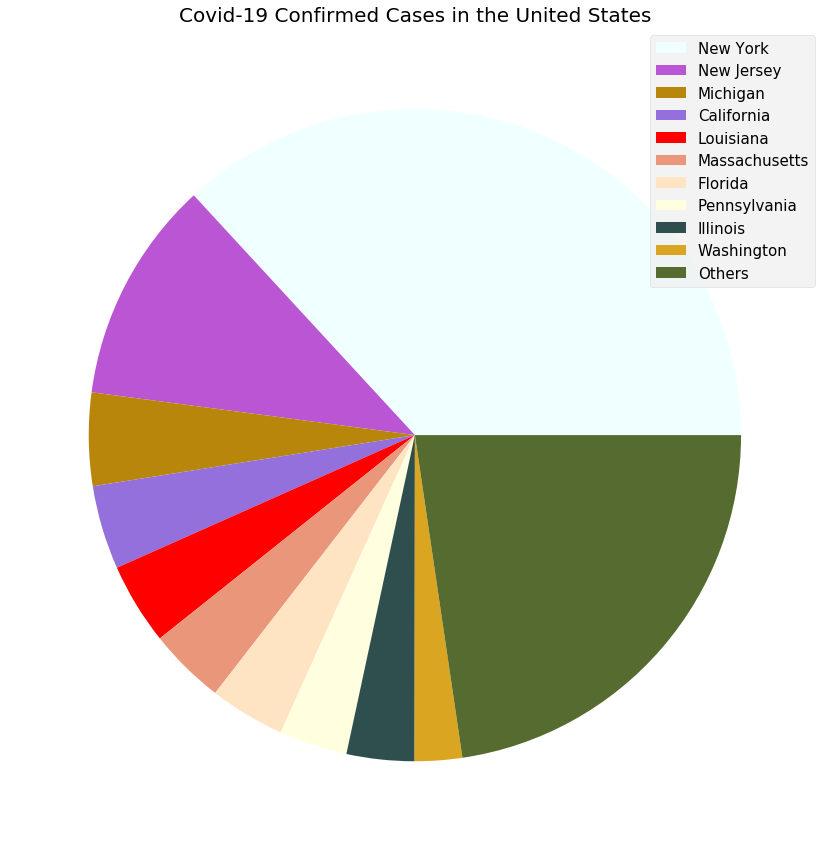

In [155]:
c = random.sample(list(mcolors.CSS4_COLORS.values()),k = len(us_confirmed_cases))
plt.figure(figsize=(20,15))
plt.title('Covid-19 Confirmed Cases in the United States',  size=20)
plt.pie(us_confirmed_cases_10, colors=c)
plt.legend(us_regions_10, loc='best', fontsize=15)
plt.show()

In [156]:
# looking at Chinese provinces
china_regions = list(latest_data[latest_data['Country_Region']=='China']['Province_State'].unique())
china_confirmed_cases = []
no_cases = [] 
for i in china_regions:
    cases = latest_data[latest_data['Province_State']==i]['Confirmed'].sum()
    if cases > 0:
        china_confirmed_cases.append(cases)
    else:
        no_cases.append(i)
 
# remove areas with no confirmed cases
for i in no_cases:
    china_confirmed_cases.remove(i)
    
china_regions = [k for k, v in sorted(zip(china_regions, china_confirmed_cases), key=operator.itemgetter(1), reverse=True)]

for i in range(len(china_regions)):
    china_confirmed_cases[i] = latest_data[latest_data['Province_State']==china_regions[i]]['Confirmed'].sum()  

china_regions_10 = china_regions[:10]
china_regions_10.append('Others')
china_confirmed_cases_10 = china_confirmed_cases[:10]
china_confirmed_cases_10.append(np.sum(china_confirmed_cases[10:]))

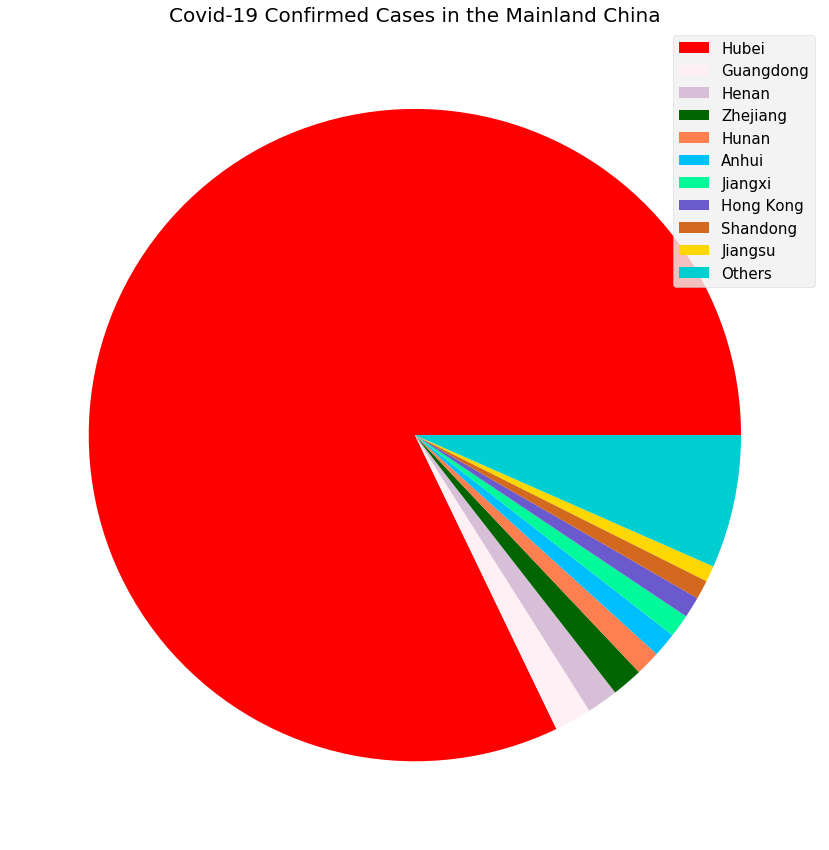

In [157]:
c = random.sample(list(mcolors.CSS4_COLORS.values()),k = len(china_confirmed_cases))
plt.figure(figsize=(20,15))
plt.title('Covid-19 Confirmed Cases in the Mainland China', size=20)
plt.pie(china_confirmed_cases_10, colors=c)
plt.legend(china_regions_10, loc='best', fontsize=15)
plt.show()

In [158]:
confirmed = pd.read_csv("time_series_covid_19_confirmed.csv")
deaths = pd.read_csv("time_series_covid_19_deaths.csv")

Text(0, 0.5, 'New Confirmed')

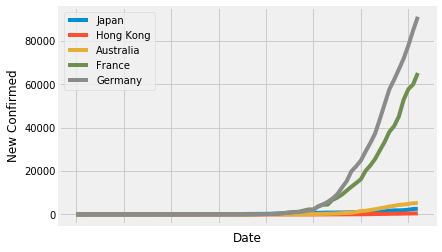

In [162]:
confirmed[confirmed["Country/Region"]=="Japan"].sum()['1/22/20':confirmed.columns[-1]].plot(label="Japan")
confirmed[confirmed["Country/Region"]=="Tunisia"].sum()['1/22/20':confirmed.columns[-1]].plot(label="Hong Kong")
confirmed[confirmed["Country/Region"]=="Australia"].sum()['1/22/20':confirmed.columns[-1]].plot(label="Australia")
# confirmed[confirmed["Country/Region"]=="Italy"].sum()['1/22/20':confirmed.columns[-1]].plot(label="Italy")
# confirmed[confirmed["Country/Region"]=="South Korea"].sum()['1/22/20':confirmed.columns[-1]].plot(label="South Korea")
# confirmed[confirmed["Country/Region"]=="Iran"].sum()['1/22/20':confirmed.columns[-1]].plot(label="Iran")
confirmed[confirmed["Country/Region"]=="France"].sum()['1/22/20':confirmed.columns[-1]].plot(label="France")
confirmed[confirmed["Country/Region"]=="Germany"].sum()['1/22/20':confirmed.columns[-1]].plot(label="Germany")
plt.legend()
plt.xlabel("Date")
plt.ylabel("New Confirmed")

In [163]:
confirmed[confirmed["Country/Region"]=="Tunisia"]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20
212,NaN,Tunisia,34.0,9.0,0,0,0,0,0,0,...,173,197,227,278,312,312,394,423,455,495


In [166]:
from scipy.optimize import curve_fit
import numpy as np

def nonlinear_fit(x, a, b):
    return a ** (x-b)
# param, cov = curve_fit(nonlinear_fit, array_x, array_y)# confirmed[confirmed["Country/Region"]=="US"].sum()['1/22/20':confirmed.columns[-1]]

def sum_data(country, data):
    tmp = data[data["Country/Region"]==country].sum()['1/22/20':confirmed.columns[-1]]
    if tmp[-2] == 0:
        return tmp[:-2]
    elif tmp[-1] == 0:
        return tmp[:-1]
    else:
        return tmp
confirmed_sum_jpn = sum_data("Japan", confirmed)
confirmed_sum_it= sum_data("Italy", confirmed)
confirmed_sum_ir= sum_data("Iran", confirmed)
confirmed_sum_fr = sum_data("France", confirmed)
confirmed_sum_ger = sum_data("Germany", confirmed)
confirmed_sum_us = sum_data("US", confirmed)
confirmed_sum_sp = sum_data("Spain", confirmed)
confirmed_sum_mc = sum_data("China", confirmed)
confirmed_sum_sw = sum_data("Switzerland", confirmed)
confirmed_sum_ne = sum_data("Netherlands", confirmed)
confirmed_sum_uk = sum_data("UK", confirmed)
deaths_sum_mc = sum_data("China", deaths)
deaths_sum_it = sum_data("Italy", deaths)
deaths_sum_sp = sum_data("Spain", deaths)
deaths_sum_ir = sum_data("Iran", deaths)
deaths_sum_us = sum_data("US", deaths)
deaths_sum_uk = sum_data("UK", deaths)
deaths_sum_fr = sum_data("France", deaths)
deaths_sum_jp = sum_data("Tunisia", deaths)

# # confirmed_sum_jpn = confirmed[confirmed["Country/Region"]=="Japan"].sum()['1/22/20':confirmed.columns[-1]]
# confirmed_sum_it = confirmed[confirmed["Country/Region"]=="Italy"].sum()['1/22/20':confirmed.columns[-1]]
# cond_kr = (confirmed["Country/Region"]=='Republic of Korea') | (confirmed["Country/Region"]=='Korea, South') 
# confirmed_sum_kr = confirmed[cond_kr].sum()['1/22/20':confirmed.columns[-1]]
# # confirmed_sum_kr = confirmed[confirmed["Country/Region"]=="South Korea"].sum()['1/22/20':confirmed.columns[-1]]
# # confirmed_sum_kr = confirmed[confirmed["Country/Region"]=='Korea, South'].sum()['1/22/20':confirmed.columns[-1]] 
# cond_ir = (confirmed["Country/Region"]=='Iran') | (confirmed["Country/Region"]=='Iran (Islamic Republic of)') 

# confirmed_sum_ir = confirmed[cond_ir].sum()['1/22/20':confirmed.columns[-1]]
# confirmed_sum_fr = confirmed[confirmed["Country/Region"]=="France"].sum()['1/22/20':confirmed.columns[-1]]
# confirmed_sum_ger = confirmed[confirmed["Country/Region"]=="Germany"].sum()['1/22/20':confirmed.columns[-1]]
# confirmed_sum_us = confirmed[confirmed["Country/Region"]=="US"].sum()['1/22/20':confirmed.columns[-1]]
# confirmed_sum_sp = confirmed[confirmed["Country/Region"]=="Spain"].sum()['1/22/20':confirmed.columns[-1]]
# cond_ch = (confirmed["Country/Region"]=='China') | (confirmed["Country/Region"]=='Mainland China') 
# confirmed_sum_mc = confirmed[cond_ch].sum()['1/22/20':confirmed.columns[-1]]
# confirmed_sum_sw = confirmed[confirmed["Country/Region"]=="Switzerland"].sum()['1/22/20':confirmed.columns[-1]]
# confirmed_sum_ne = confirmed[confirmed["Country/Region"]=="Netherlands"].sum()['1/22/20':confirmed.columns[-1]]
# confirmed_sum_uk = confirmed[confirmed["Country/Region"]=="UK"].sum()['1/22/20':confirmed.columns[-1]]

# deaths_sum_mc = deaths[cond_ch].sum()['1/22/20':confirmed.columns[-1]]
# deaths_sum_it = deaths[deaths["Country/Region"]=="Italy"].sum()['1/22/20':confirmed.columns[-1]]
# deaths_sum_sp = deaths[deaths["Country/Region"]=="Spain"].sum()['1/22/20':confirmed.columns[-1]]
# deaths_sum_ir = deaths[deaths["Country/Region"]=="Iran"].sum()['1/22/20':confirmed.columns[-1]]

<BarContainer object of 72 artists>

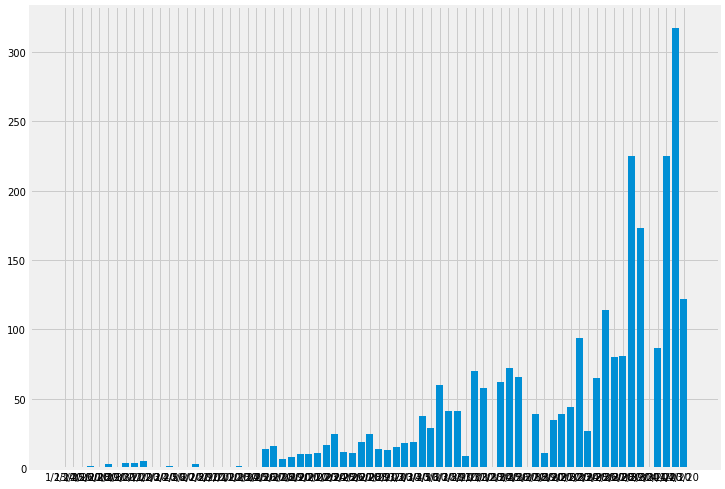

In [167]:
plt.figure(figsize=(11, 8.5))

plt.bar(confirmed_sum_jpn.index[1:], np.diff(confirmed_sum_jpn), label="Tunisia", width=0.8)

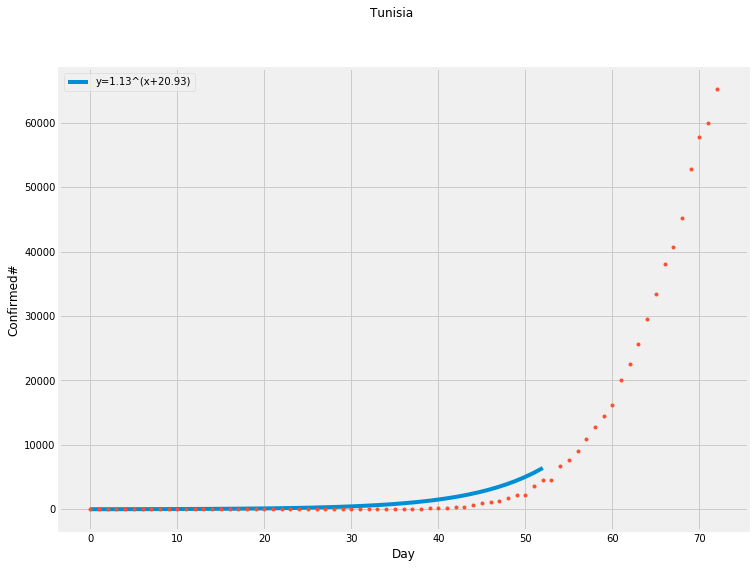

In [168]:
xpoints = np.linspace(0, 52)

_data = confirmed_sum_fr

param, cov = curve_fit(nonlinear_fit, [_ for _ in range(len(_data))], np.array(_data))
plt.figure(figsize=(11, 8.5))
plt.plot(xpoints, nonlinear_fit(xpoints, param[0], param[1]), 
         label="y={0:.2f}^(x{1:+.2f})".format(param[0], -param[1]))
plt.plot([_ for _ in range(len(_data))], _data, ".")
plt.xlabel("Day")
plt.ylabel("Confirmed#")
plt.legend()
plt.suptitle("Tunisia")
plt.savefig("TN.png")

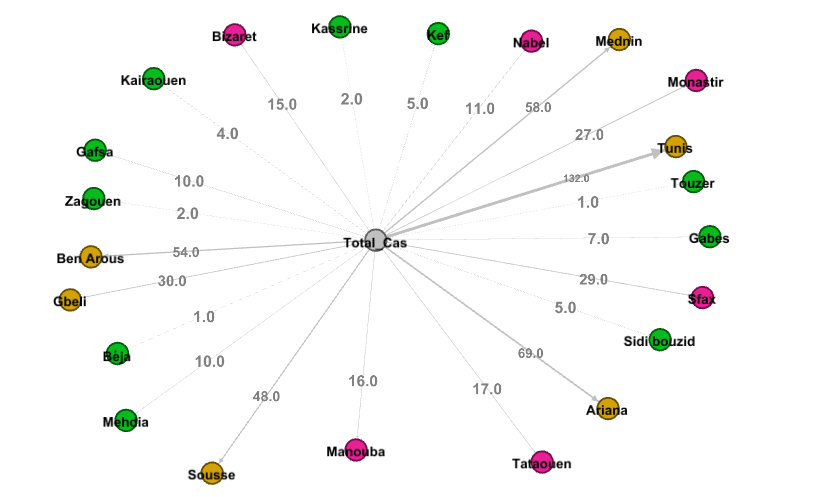

In [169]:
from IPython.display import Image
Image(filename="capture.png")

##### Here, the knowledge graph using gephi in tunisia